In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import PCA
import warnings
from datetime import datetime
import time

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("MUSIC GENRE CLASSIFICATION: BASELINE AND ENSEMBLE METHODS")
print("Implementation based on SongNet Paper")
print("="*80)
print(f"\nNotebook started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

MUSIC GENRE CLASSIFICATION: BASELINE AND ENSEMBLE METHODS
Implementation based on SongNet Paper

Notebook started at: 2025-10-12 13:51:20


In [4]:
print("\n" + "="*80)
print("STEP 1: DATA LOADING")
print("="*80 + "\n")

print("Loading tracks metadata...")
start_time = time.time()
tracks = pd.read_csv('tracks.csv', header=[0, 1], index_col=0)
print(f"✓ Tracks loaded in {time.time()-start_time:.2f} seconds")
print(f"  Shape: {tracks.shape}")

print("\nLoading audio features...")
start_time = time.time()
features = pd.read_csv('features.csv', header=[0, 1, 2], index_col=0)
print(f"✓ Features loaded in {time.time()-start_time:.2f} seconds")
print(f"  Shape: {features.shape}")

# Filter for small subset
fma_small = tracks['set', 'subset'] == 'small'
X = features.loc[fma_small, 'mfcc']
y = tracks.loc[fma_small, ('track', 'genre_top')]

print(f"\nFiltered FMA-Small Dataset:")
print(f"  - Total samples: {len(X)}")
print(f"  - Number of MFCC features: {X.shape[1]}")
print(f"  - Number of genres: {y.nunique()}")


STEP 1: DATA LOADING

Loading tracks metadata...
✓ Tracks loaded in 1.90 seconds
  Shape: (106574, 52)

Loading audio features...
✓ Features loaded in 5.69 seconds
  Shape: (106574, 518)

Filtered FMA-Small Dataset:
  - Total samples: 8000
  - Number of MFCC features: 140
  - Number of genres: 8



EXPLORATORY DATA ANALYSIS

Genre Distribution:
--------------------------------------------------
  Electronic             1000 samples ( 12.5%)
  Experimental           1000 samples ( 12.5%)
  Folk                   1000 samples ( 12.5%)
  Hip-Hop                1000 samples ( 12.5%)
  Instrumental           1000 samples ( 12.5%)
  International          1000 samples ( 12.5%)
  Pop                    1000 samples ( 12.5%)
  Rock                   1000 samples ( 12.5%)
--------------------------------------------------


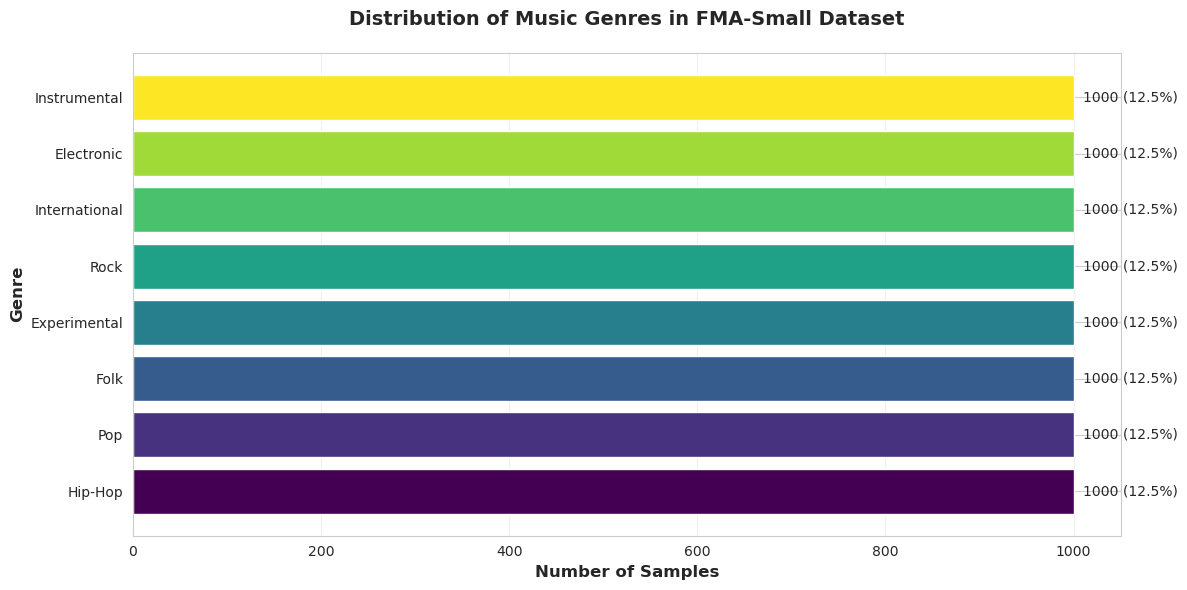


Observation: Dataset is balanced with 1000 samples per genre


In [5]:
print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80 + "\n")

genres = y.unique().tolist()
genre_counts = y.value_counts()

print("Genre Distribution:")
print("-" * 50)
for genre in sorted(genres):
    count = genre_counts[genre]
    percentage = (count/len(y))*100
    print(f"  {genre:<20} {count:>6} samples ({percentage:>5.1f}%)")
print("-" * 50)

# Visualization 1: Genre Distribution Bar Plot
fig, ax = plt.subplots(figsize=(12, 6))
genre_counts_sorted = genre_counts.sort_values(ascending=True)
colors = plt.cm.viridis(np.linspace(0, 1, len(genre_counts_sorted)))
bars = ax.barh(genre_counts_sorted.index, genre_counts_sorted.values, color=colors)
ax.set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
ax.set_ylabel('Genre', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Music Genres in FMA-Small Dataset', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (genre, count) in enumerate(zip(genre_counts_sorted.index, genre_counts_sorted.values)):
    ax.text(count + 10, i, f'{count} ({count/len(y)*100:.1f}%)', 
            va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nObservation: Dataset is balanced with 1000 samples per genre")


--------------------------------------------------------------------------------
FEATURE STATISTICS
--------------------------------------------------------------------------------

MFCC Feature Statistics:
  - Number of features: 140
  - Feature range: [-1131.37, 609.26]
  - Mean of all features: 0.0855
  - Std of all features: 9.5961
  - Missing values: 0


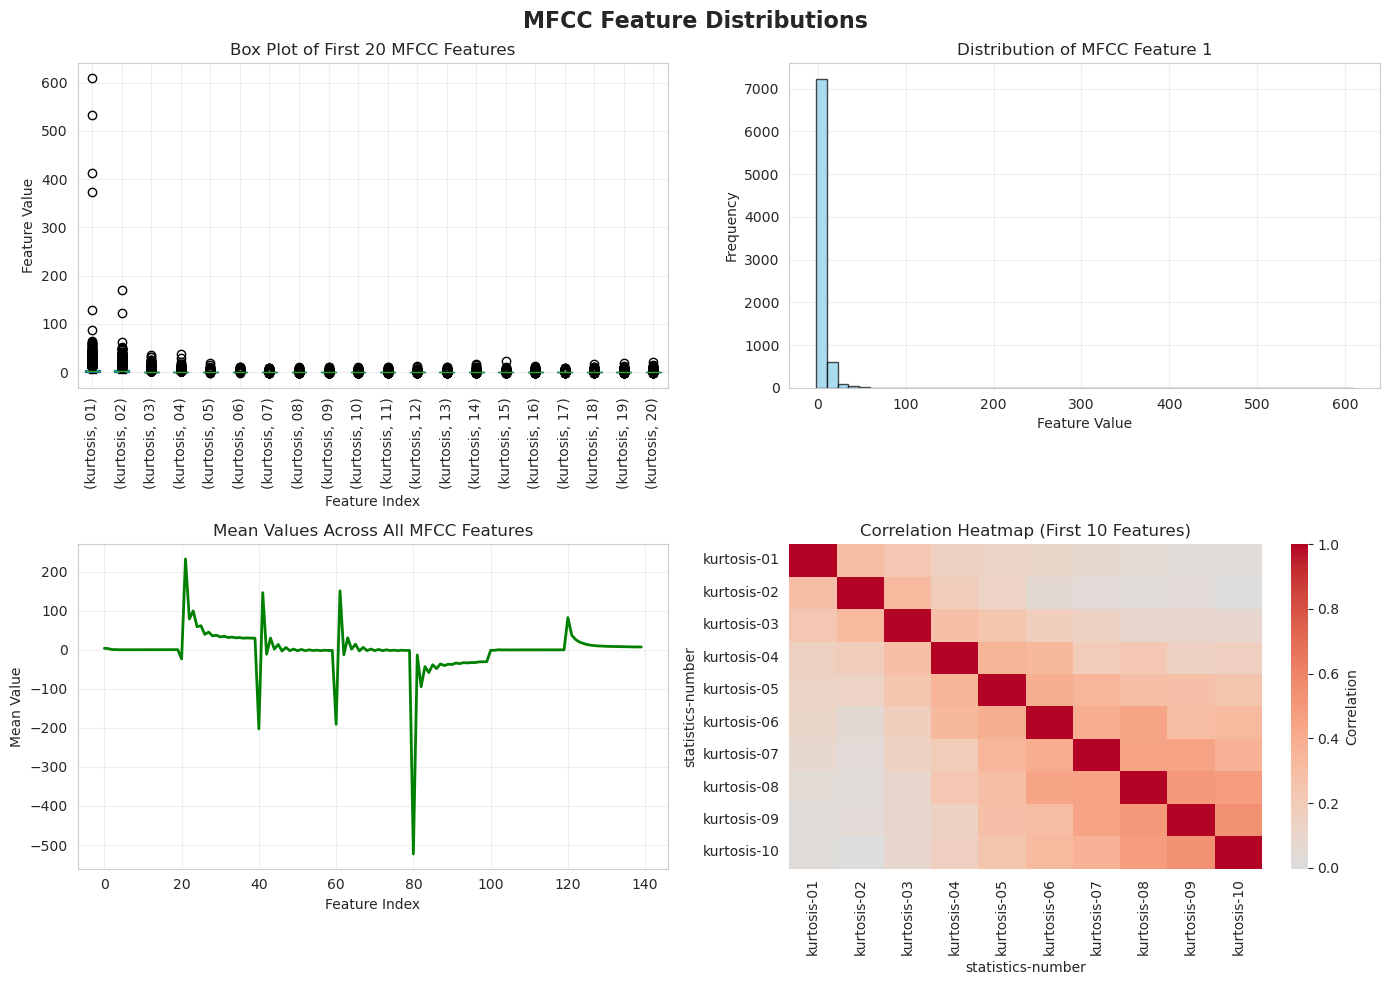

In [6]:
print("\n" + "-"*80)
print("FEATURE STATISTICS")
print("-"*80 + "\n")

print("MFCC Feature Statistics:")
print(f"  - Number of features: {X.shape[1]}")
print(f"  - Feature range: [{X.min().min():.2f}, {X.max().max():.2f}]")
print(f"  - Mean of all features: {X.mean().mean():.4f}")
print(f"  - Std of all features: {X.std().mean():.4f}")

# Check for missing values
missing = X.isnull().sum().sum()
print(f"  - Missing values: {missing}")

# Visualization 2: Feature Distribution (first 20 MFCC features)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('MFCC Feature Distributions', fontsize=16, fontweight='bold')

# Box plot of first 20 features
ax1 = axes[0, 0]
X.iloc[:, :20].boxplot(ax=ax1, rot=90)
ax1.set_title('Box Plot of First 20 MFCC Features')
ax1.set_xlabel('Feature Index')
ax1.set_ylabel('Feature Value')
ax1.grid(True, alpha=0.3)

# Histogram of first MFCC feature
ax2 = axes[0, 1]
ax2.hist(X.iloc[:, 0], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax2.set_title('Distribution of MFCC Feature 1')
ax2.set_xlabel('Feature Value')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

# Mean and std across all features
ax3 = axes[1, 0]
feature_means = X.mean()
ax3.plot(feature_means.values, color='green', linewidth=2)
ax3.set_title('Mean Values Across All MFCC Features')
ax3.set_xlabel('Feature Index')
ax3.set_ylabel('Mean Value')
ax3.grid(True, alpha=0.3)

# Feature correlation heatmap (sample)
ax4 = axes[1, 1]
corr_matrix = X.iloc[:, :10].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, ax=ax4, cbar_kws={'label': 'Correlation'})
ax4.set_title('Correlation Heatmap (First 10 Features)')

plt.tight_layout()
plt.show()



--------------------------------------------------------------------------------
DIMENSIONALITY REDUCTION VISUALIZATION
--------------------------------------------------------------------------------

Applying PCA for 2D visualization...
Explained variance ratio: [0.57972703 0.10489035]
Total variance explained: 68.46%


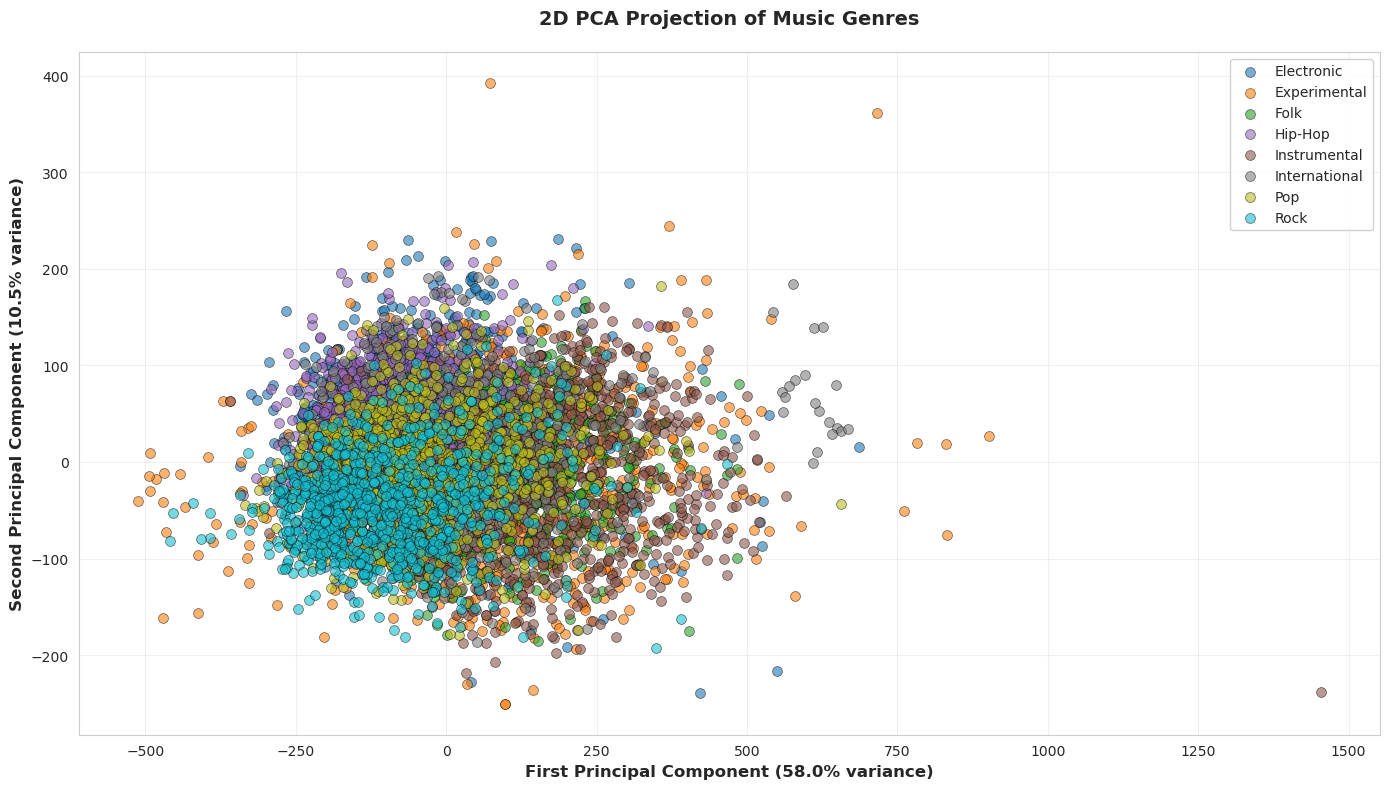


Observation: Some genres show clear clustering while others overlap,
indicating varying difficulty in classification.


In [7]:
print("\n" + "-"*80)
print("DIMENSIONALITY REDUCTION VISUALIZATION")
print("-"*80 + "\n")

print("Applying PCA for 2D visualization...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

# Visualization 3: PCA Scatter Plot
fig, ax = plt.subplots(figsize=(14, 8))

# Create color map for genres
unique_genres = sorted(genres)
colors_map = plt.cm.tab10(np.linspace(0, 1, len(unique_genres)))
genre_to_color = {genre: colors_map[i] for i, genre in enumerate(unique_genres)}

for genre in unique_genres:
    mask = y == genre
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
              c=[genre_to_color[genre]], 
              label=genre, 
              alpha=0.6, 
              s=50,
              edgecolors='black',
              linewidth=0.5)

ax.set_xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
             fontsize=12, fontweight='bold')
ax.set_ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
             fontsize=12, fontweight='bold')
ax.set_title('2D PCA Projection of Music Genres', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', framealpha=0.9, fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: Some genres show clear clustering while others overlap,")
print("indicating varying difficulty in classification.")



STEP 2: DATA SPLITTING AND FEATURE SCALING

Split Strategy: 70% Training, 20% Validation, 10% Testing
Using stratified sampling to maintain genre distribution

✓ Test set created: 800 samples (10.0%)
✓ Validation set created: 1600 samples (20.0%)
✓ Training set created: 5600 samples (70.0%)

Applying StandardScaler (zero mean, unit variance)...
✓ All datasets scaled successfully


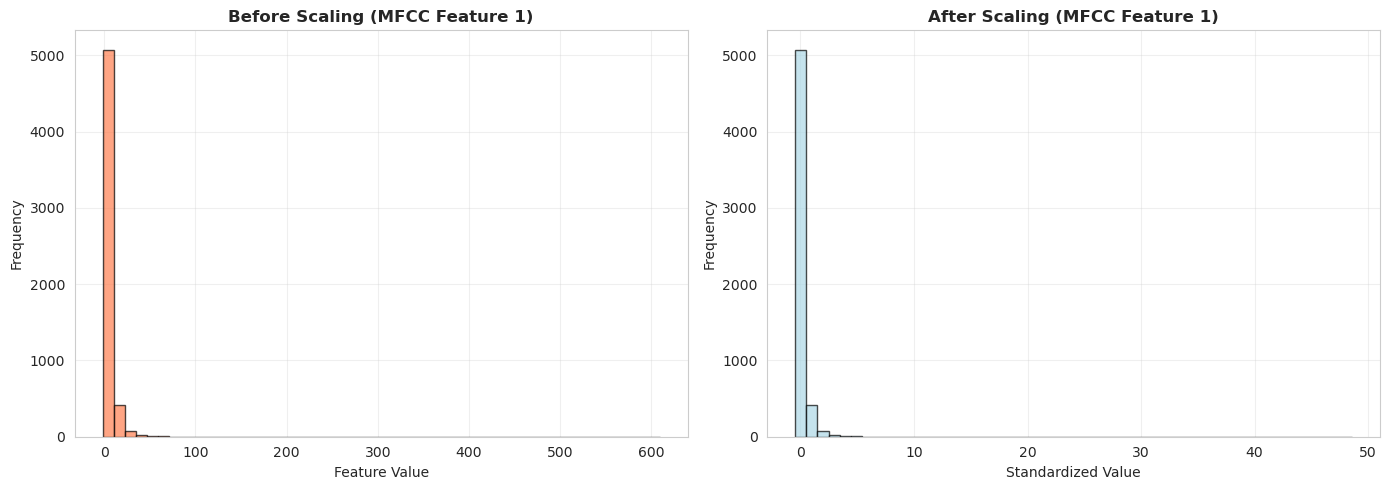


Scaling ensures all features contribute equally to model training


In [8]:
print("\n" + "="*80)
print("STEP 2: DATA SPLITTING AND FEATURE SCALING")
print("="*80 + "\n")

print("Split Strategy: 70% Training, 20% Validation, 10% Testing")
print("Using stratified sampling to maintain genre distribution\n")

total_samples = len(X)

# First split: separate test set (10%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print(f"✓ Test set created: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")

# Second split: separate validation from training
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=(2/9), random_state=42, stratify=y_train_val
)
print(f"✓ Validation set created: {len(X_val)} samples ({len(X_val)/total_samples*100:.1f}%)")
print(f"✓ Training set created: {len(X_train)} samples ({len(X_train)/total_samples*100:.1f}%)")

# Feature Scaling
print("\nApplying StandardScaler (zero mean, unit variance)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("✓ All datasets scaled successfully")

# Visualization 4: Before and After Scaling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(X_train.iloc[:, 0], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_title('Before Scaling (MFCC Feature 1)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Feature Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(X_train_scaled[:, 0], bins=50, color='lightblue', edgecolor='black', alpha=0.7)
axes[1].set_title('After Scaling (MFCC Feature 1)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Standardized Value')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nScaling ensures all features contribute equally to model training")

In [9]:
def train_and_evaluate_model(name, model, X_train, X_val, X_test, 
                             y_train, y_val, y_test, show_details=False):
    """Train and evaluate a single model"""
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    print(f"\nModel Type: {model.__class__.__name__}")
    print("\nKey Hyperparameters:")
    params = model.get_params()
    important_params = ['n_neighbors', 'metric', 'p', 'C', 'kernel', 'gamma', 'degree',
                       'hidden_layer_sizes', 'activation', 'alpha', 'solver', 'penalty',
                       'n_estimators', 'max_depth', 'learning_rate', 'voting']
    for key in important_params:
        if key in params:
            print(f"  - {key}: {params[key]}")
    
    # Training
    print("\nTraining phase...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"✓ Training completed in {train_time:.2f} seconds")
    
    # Evaluate on all sets
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    print(f"\nPerformance Summary:")
    print(f"  - Training Accuracy:   {train_accuracy:.4f}")
    print(f"  - Validation Accuracy: {val_accuracy:.4f}")
    print(f"  - Test Accuracy:       {test_accuracy:.4f}")
    print(f"  - Test F1-Score:       {test_f1:.4f}")
    print(f"  - Overfitting Gap:     {train_accuracy - test_accuracy:.4f}")
    
    # Cross-validation if requested
    if show_details:
        print("\nRunning 5-fold cross-validation...")
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        print(f"  CV Accuracies: {[f'{s:.4f}' for s in cv_scores]}")
        print(f"  CV Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    return {
        'model': model,
        'train_time': train_time,
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'val_f1': val_f1,
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'y_pred': y_test_pred
    }



STEP 3: MODEL TRAINING - K-NEAREST NEIGHBORS

Exploring different distance metrics and k values


Training: KNN (k=5, Euclidean)

Model Type: KNeighborsClassifier

Key Hyperparameters:
  - n_neighbors: 5
  - metric: euclidean
  - p: 2

Training phase...
✓ Training completed in 0.01 seconds

Performance Summary:
  - Training Accuracy:   0.6514
  - Validation Accuracy: 0.4744
  - Test Accuracy:       0.4825
  - Test F1-Score:       0.4734
  - Overfitting Gap:     0.1689

Running 5-fold cross-validation...
  CV Accuracies: ['0.4911', '0.4911', '0.4893', '0.4643', '0.4768']
  CV Mean: 0.4825 (+/- 0.0106)

Training: KNN (k=5, Manhattan)

Model Type: KNeighborsClassifier

Key Hyperparameters:
  - n_neighbors: 5
  - metric: manhattan
  - p: 2

Training phase...
✓ Training completed in 0.01 seconds

Performance Summary:
  - Training Accuracy:   0.6686
  - Validation Accuracy: 0.4731
  - Test Accuracy:       0.5088
  - Test F1-Score:       0.5005
  - Overfitting Gap:     0.1598

Training: KNN 

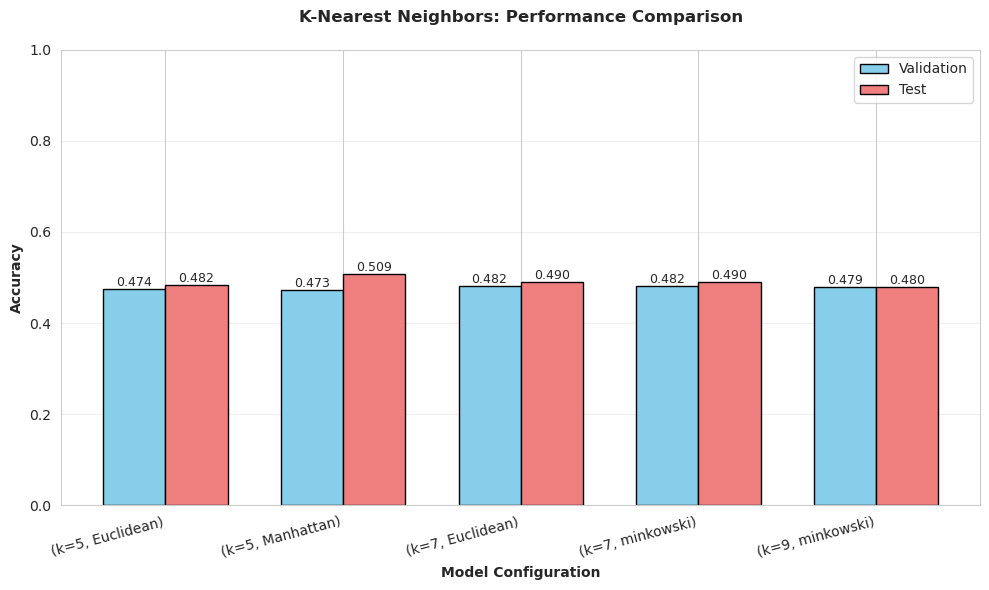

In [10]:
print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - K-NEAREST NEIGHBORS")
print("="*80)
print("\nExploring different distance metrics and k values\n")

knn_models = {
    "KNN (k=5, Euclidean)": KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
    "KNN (k=5, Manhattan)": KNeighborsClassifier(n_neighbors=5, metric='manhattan'),
    "KNN (k=7, Euclidean)": KNeighborsClassifier(n_neighbors=7, metric='euclidean'),
    "KNN (k=7, minkowski)": KNeighborsClassifier(n_neighbors=7, metric='minkowski'),
    "KNN (k=9, minkowski)": KNeighborsClassifier(n_neighbors=9, metric='minkowski'),
}

knn_results = {}
for name, model in knn_models.items():
    result = train_and_evaluate_model(
        name, model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, show_details=(name == "KNN (k=5, Euclidean)")
    )
    knn_results[name] = result

# Visualization: KNN Comparison
fig, ax = plt.subplots(figsize=(10, 6))
names = list(knn_results.keys())
test_accs = [knn_results[n]['test_accuracy'] for n in names]
val_accs = [knn_results[n]['val_accuracy'] for n in names]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='lightcoral', edgecolor='black')

ax.set_xlabel('Model Configuration', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('K-Nearest Neighbors: Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([n.replace('KNN ', '') for n in names], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


STEP 3: MODEL TRAINING - LOGISTIC REGRESSION

Testing different regularization strengths


Training: Logistic Regression (C=1.0)

Model Type: LogisticRegression

Key Hyperparameters:
  - C: 1.0
  - solver: lbfgs
  - penalty: l2

Training phase...
✓ Training completed in 0.59 seconds

Performance Summary:
  - Training Accuracy:   0.5627
  - Validation Accuracy: 0.4894
  - Test Accuracy:       0.5175
  - Test F1-Score:       0.5108
  - Overfitting Gap:     0.0452

Running 5-fold cross-validation...
  CV Accuracies: ['0.5107', '0.4750', '0.5062', '0.4795', '0.5098']
  CV Mean: 0.4962 (+/- 0.0157)

Training: Logistic Regression (C=10.0)

Model Type: LogisticRegression

Key Hyperparameters:
  - C: 10.0
  - solver: lbfgs
  - penalty: l2

Training phase...
✓ Training completed in 0.55 seconds

Performance Summary:
  - Training Accuracy:   0.5650
  - Validation Accuracy: 0.4850
  - Test Accuracy:       0.5125
  - Test F1-Score:       0.5059
  - Overfitting Gap:     0.0525

Training: Logistic 

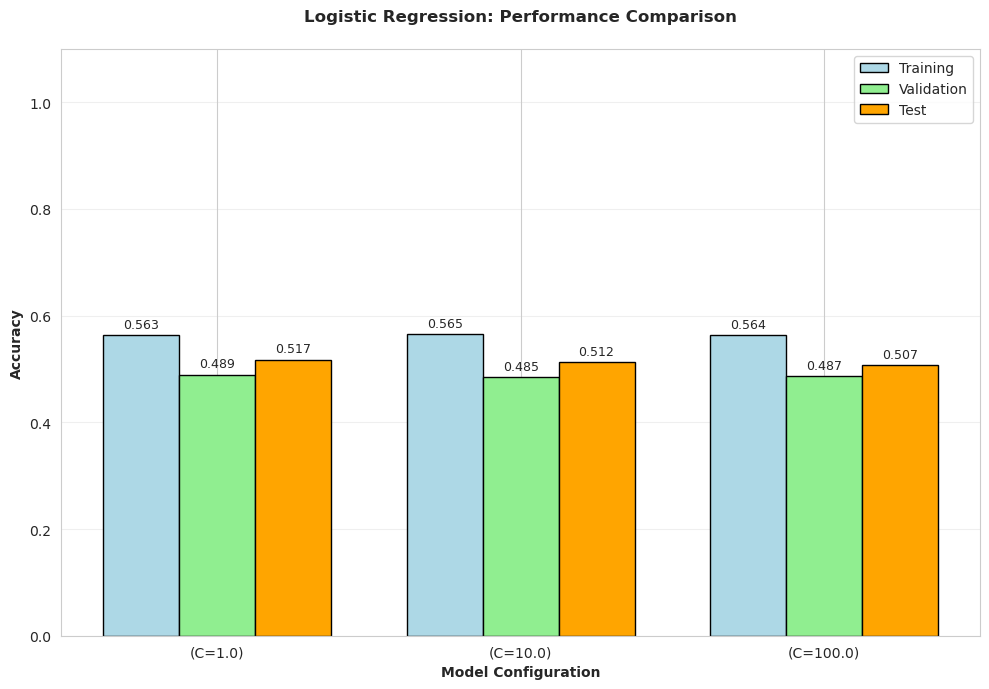

In [11]:
print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - LOGISTIC REGRESSION")
print("="*80)
print("\nTesting different regularization strengths\n")

lr_models = {
    "Logistic Regression (C=1.0)": LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42),
    "Logistic Regression (C=10.0)": LogisticRegression(C=10.0, solver='lbfgs', max_iter=1000, random_state=42),
    "Logistic Regression (C=100.0)": LogisticRegression(C=100.0, solver='lbfgs', max_iter=1000, random_state=42)
}

lr_results = {}
for name, model in lr_models.items():
    result = train_and_evaluate_model(
        name, model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, show_details=(name == "Logistic Regression (C=1.0)")
    )
    lr_results[name] = result

# Visualization: Logistic Regression Comparison with Training Accuracy
fig, ax = plt.subplots(figsize=(10, 7))
names = list(lr_results.keys())
train_accs = [lr_results[n]['train_accuracy'] for n in names]
val_accs = [lr_results[n]['val_accuracy'] for n in names]
test_accs = [lr_results[n]['test_accuracy'] for n in names]

x = np.arange(len(names))
width = 0.25

bars1 = ax.bar(x - width, train_accs, width, label='Training', color='lightblue', edgecolor='black')
bars2 = ax.bar(x, val_accs, width, label='Validation', color='lightgreen', edgecolor='black')
bars3 = ax.bar(x + width, test_accs, width, label='Test', color='orange', edgecolor='black')

ax.set_xlabel('Model Configuration', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Logistic Regression: Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([n.replace('Logistic Regression ', '') for n in names], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

fig.tight_layout()
plt.show()



STEP 3: MODEL TRAINING - MULTILAYER PERCEPTRON

Exploring architectures, activation functions, and solvers


Training: MLP (100, ReLU, Adam)

Model Type: MLPClassifier

Key Hyperparameters:
  - hidden_layer_sizes: (100,)
  - activation: relu
  - alpha: 0.0001
  - solver: adam
  - learning_rate: constant

Training phase...
✓ Training completed in 8.21 seconds

Performance Summary:
  - Training Accuracy:   0.9702
  - Validation Accuracy: 0.4550
  - Test Accuracy:       0.4512
  - Test F1-Score:       0.4506
  - Overfitting Gap:     0.5189

Running 5-fold cross-validation...
  CV Accuracies: ['0.5018', '0.4902', '0.4875', '0.4634', '0.4786']
  CV Mean: 0.4843 (+/- 0.0128)

Training: MLP (100,50, ReLU, Adam)

Model Type: MLPClassifier

Key Hyperparameters:
  - hidden_layer_sizes: (100, 50)
  - activation: relu
  - alpha: 0.0001
  - solver: adam
  - learning_rate: constant

Training phase...
✓ Training completed in 6.04 seconds

Performance Summary:
  - Training Accuracy:   0.9998
  - Vali

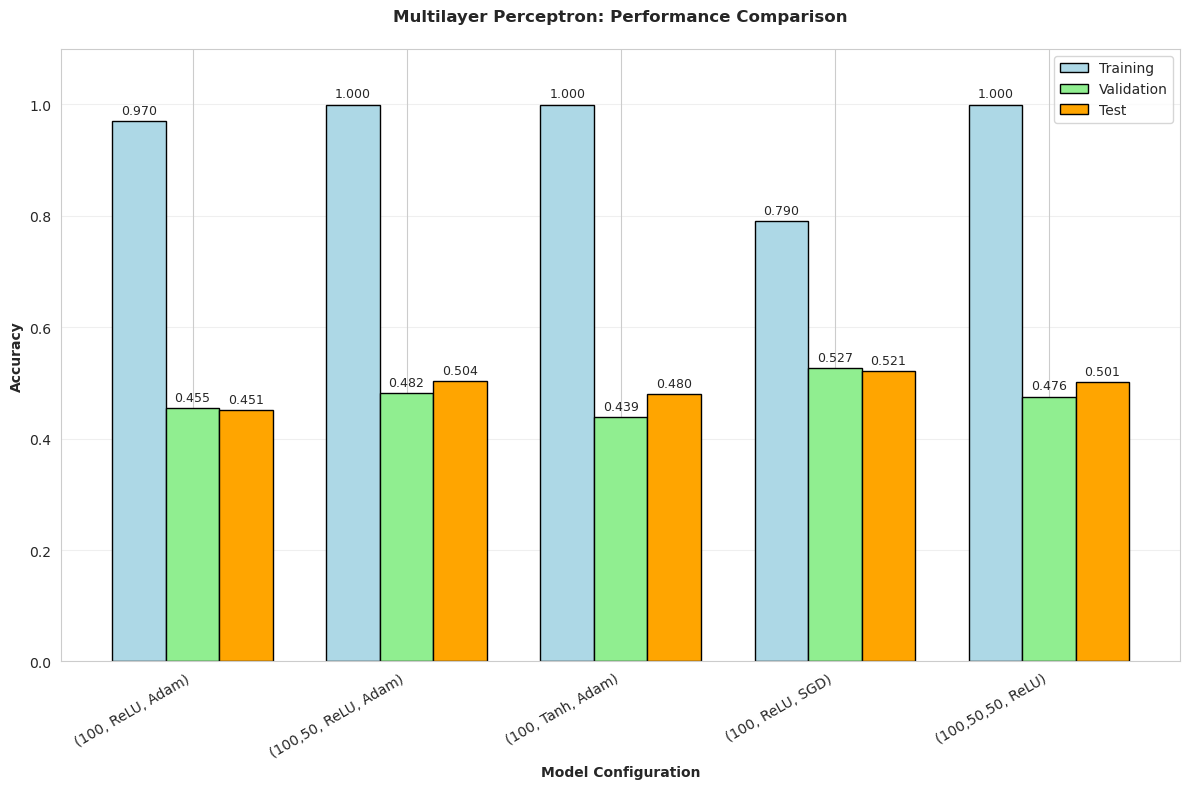

In [28]:


print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - MULTILAYER PERCEPTRON")
print("="*80)
print("\nExploring architectures, activation functions, and solvers\n")

# Updated set of MLP models focusing on your requested hyperparameters
mlp_models = {
    "MLP (100, ReLU, Adam)": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42),
    "MLP (100,50, ReLU, Adam)": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42),
    "MLP (100, Tanh, Adam)": MLPClassifier(hidden_layer_sizes=(100,), activation='tanh', solver='adam', max_iter=500, random_state=42),
    "MLP (100, ReLU, SGD)": MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='sgd', max_iter=500, random_state=42),
    "MLP (100,50,50, ReLU)": MLPClassifier(hidden_layer_sizes=(100, 50, 50), activation='relu', max_iter=500, random_state=42)
}

mlp_results = {}
for name, model in mlp_models.items():
    result = train_and_evaluate_model(
        name, model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, show_details=(name == "MLP (100, ReLU, Adam)")
    )
    mlp_results[name] = result

# Visualization: Multilayer Perceptron Comparison
fig, ax = plt.subplots(figsize=(12, 8))
names = list(mlp_results.keys())
train_accs = [mlp_results[n]['train_accuracy'] for n in names]
val_accs = [mlp_results[n]['val_accuracy'] for n in names]
test_accs = [mlp_results[n]['test_accuracy'] for n in names]

x = np.arange(len(names))
width = 0.25

bars1 = ax.bar(x - width, train_accs, width, label='Training', color='lightblue', edgecolor='black')
bars2 = ax.bar(x, val_accs, width, label='Validation', color='lightgreen', edgecolor='black')
bars3 = ax.bar(x + width, test_accs, width, label='Test', color='orange', edgecolor='black')

ax.set_xlabel('Model Configuration', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Multilayer Perceptron: Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([n.replace('MLP ', '') for n in names], rotation=30, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

fig.tight_layout()
plt.show()



STEP 3: MODEL TRAINING - SUPPORT VECTOR MACHINE

Testing different kernels and regularization


Training: SVM (Linear, C=1.0)

Model Type: SVC

Key Hyperparameters:
  - C: 1.0
  - kernel: linear
  - gamma: scale
  - degree: 3

Training phase...
✓ Training completed in 11.77 seconds

Performance Summary:
  - Training Accuracy:   0.6112
  - Validation Accuracy: 0.4825
  - Test Accuracy:       0.5100
  - Test F1-Score:       0.5058
  - Overfitting Gap:     0.1012

Running 5-fold cross-validation...
  CV Accuracies: ['0.4893', '0.4714', '0.4911', '0.4795', '0.5018']
  CV Mean: 0.4866 (+/- 0.0104)

Training: SVM (RBF, C=1.0)

Model Type: SVC

Key Hyperparameters:
  - C: 1.0
  - kernel: rbf
  - gamma: scale
  - degree: 3

Training phase...
✓ Training completed in 1.88 seconds

Performance Summary:
  - Training Accuracy:   0.7593
  - Validation Accuracy: 0.5381
  - Test Accuracy:       0.5725
  - Test F1-Score:       0.5691
  - Overfitting Gap:     0.1868

Training: SVM (Linear, C=10.0)

Mod

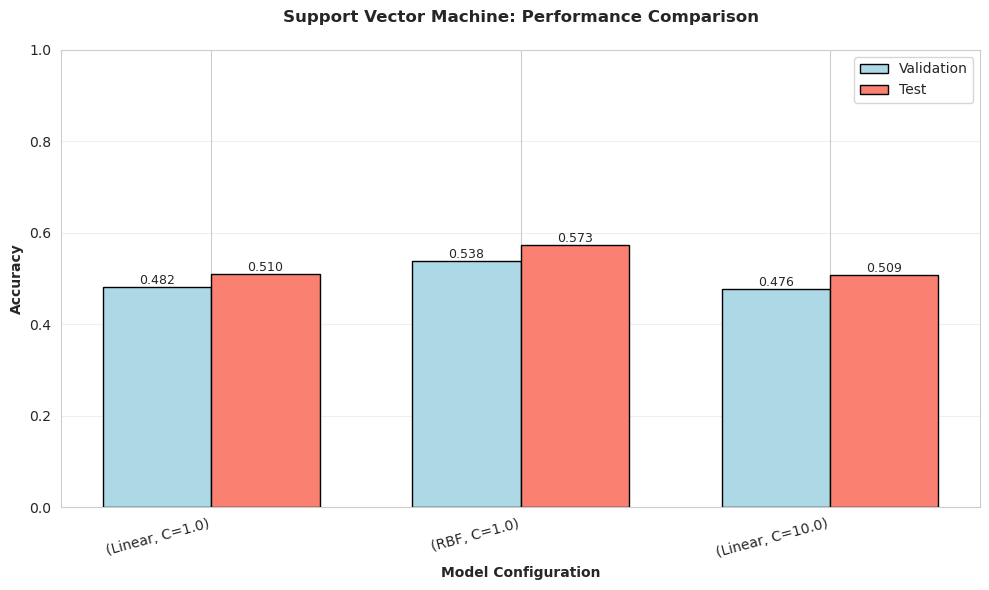

In [30]:
print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - SUPPORT VECTOR MACHINE")
print("="*80)
print("\nTesting different kernels and regularization\n")

svm_models = {
    "SVM (Linear, C=1.0)": SVC(kernel='linear', C=1.0, random_state=42),
    "SVM (RBF, C=1.0)": SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42),
    "SVM (Linear, C=10.0)": SVC(kernel='linear', C=10.0, random_state=42)
}

svm_results = {}
for name, model in svm_models.items():
    result = train_and_evaluate_model(
        name, model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, show_details=(name == "SVM (Linear, C=1.0)")
    )
    svm_results[name] = result

# Visualization: SVM Comparison
fig, ax = plt.subplots(figsize=(10, 6))
names = list(svm_results.keys())
test_accs = [svm_results[n]['test_accuracy'] for n in names]
val_accs = [svm_results[n]['val_accuracy'] for n in names]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='lightblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='salmon', edgecolor='black')

ax.set_xlabel('Model Configuration', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Support Vector Machine: Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([n.replace('SVM ', '') for n in names], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


STEP 3: MODEL TRAINING - ENSEMBLE METHODS

Training ensemble models


Training: Random Forest (n=100)

Model Type: RandomForestClassifier

Key Hyperparameters:
  - n_estimators: 100
  - max_depth: None

Training phase...
✓ Training completed in 4.77 seconds

Performance Summary:
  - Training Accuracy:   0.9998
  - Validation Accuracy: 0.5031
  - Test Accuracy:       0.5138
  - Test F1-Score:       0.5042
  - Overfitting Gap:     0.4861

Running 5-fold cross-validation...
  CV Accuracies: ['0.5429', '0.5107', '0.5518', '0.4982', '0.5214']
  CV Mean: 0.5250 (+/- 0.0199)

Training: Gradient Boosting (n=100)

Model Type: GradientBoostingClassifier

Key Hyperparameters:
  - n_estimators: 100
  - max_depth: 3
  - learning_rate: 0.1

Training phase...
✓ Training completed in 188.13 seconds

Performance Summary:
  - Training Accuracy:   0.8298
  - Validation Accuracy: 0.4994
  - Test Accuracy:       0.5325
  - Test F1-Score:       0.5307
  - Overfitting Gap:     0.2973

Training: Voting Class

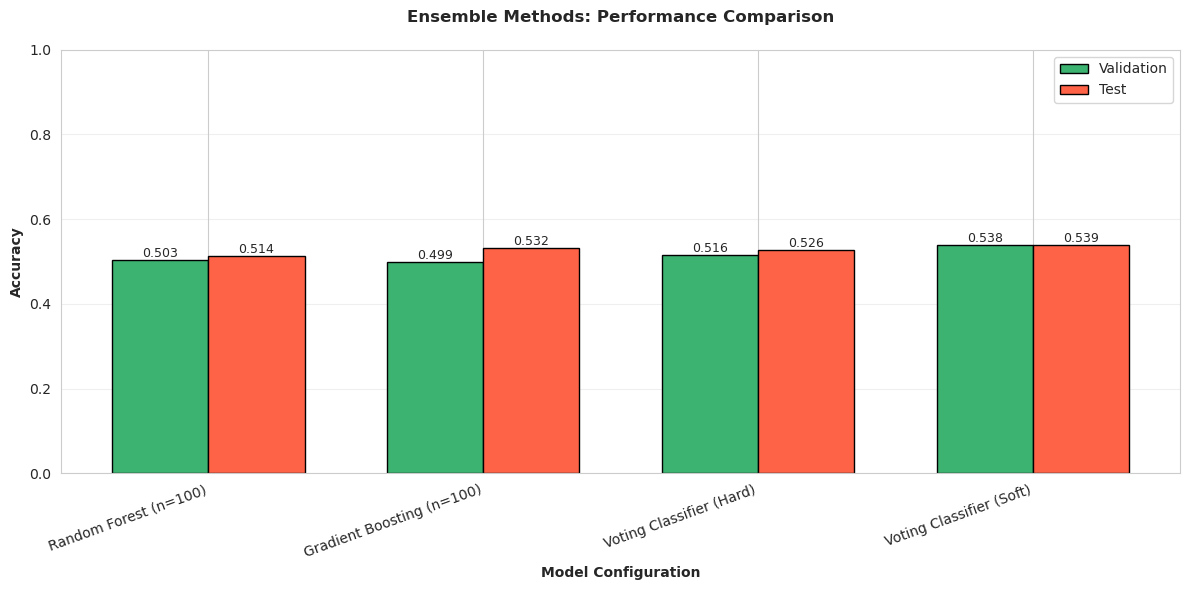

In [32]:
print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - ENSEMBLE METHODS")
print("="*80)
print("\nTraining ensemble models\n")

# Base models for voting
base_knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
base_lr = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
base_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500, random_state=42)
base_svm = SVC(kernel='linear', C=1.0, random_state=42, probability=True)

ensemble_models = {
    "Random Forest (n=100)": RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42),
    "Gradient Boosting (n=100)": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    "Voting Classifier (Hard)": VotingClassifier(estimators=[('knn', base_knn), ('lr', base_lr), ('mlp', base_mlp), ('svm', base_svm)], voting='hard'),
    "Voting Classifier (Soft)": VotingClassifier(estimators=[('knn', base_knn), ('lr', base_lr), ('mlp', base_mlp), ('svm', base_svm)], voting='soft')
}

ensemble_results = {}
for name, model in ensemble_models.items():
    result = train_and_evaluate_model(
        name, model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, show_details=(name == "Random Forest (n=100)")
    )
    ensemble_results[name] = result

# Visualization: Ensemble Comparison
fig, ax = plt.subplots(figsize=(12, 6))
names = list(ensemble_results.keys())
test_accs = [ensemble_results[n]['test_accuracy'] for n in names]
val_accs = [ensemble_results[n]['val_accuracy'] for n in names]

x = np.arange(len(names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='mediumseagreen', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='tomato', edgecolor='black')

ax.set_xlabel('Model Configuration', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Ensemble Methods: Performance Comparison', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=20, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



STEP 4: OVERALL RESULTS COMPARISON

Performance Ranking (by Test Accuracy):

Rank   Model                                      Test Acc    Val Acc   F1-Score
--------------------------------------------------------------------------------
1      SVM (RBF, C=1.0)                             0.5725     0.5381     0.5691
2      Voting Classifier (Soft)                     0.5387     0.5381     0.5356
3      Gradient Boosting (n=100)                    0.5325     0.4994     0.5307
4      Voting Classifier (Hard)                     0.5262     0.5156     0.5189
5      MLP (100, ReLU, SGD)                         0.5212     0.5269     0.5185
6      Logistic Regression (C=1.0)                  0.5175     0.4894     0.5108
7      Random Forest (n=100)                        0.5138     0.5031     0.5042
8      Logistic Regression (C=10.0)                 0.5125     0.4850     0.5059
9      SVM (Linear, C=1.0)                          0.5100     0.4825     0.5058
10     KNN (k=5, Manhattan)    

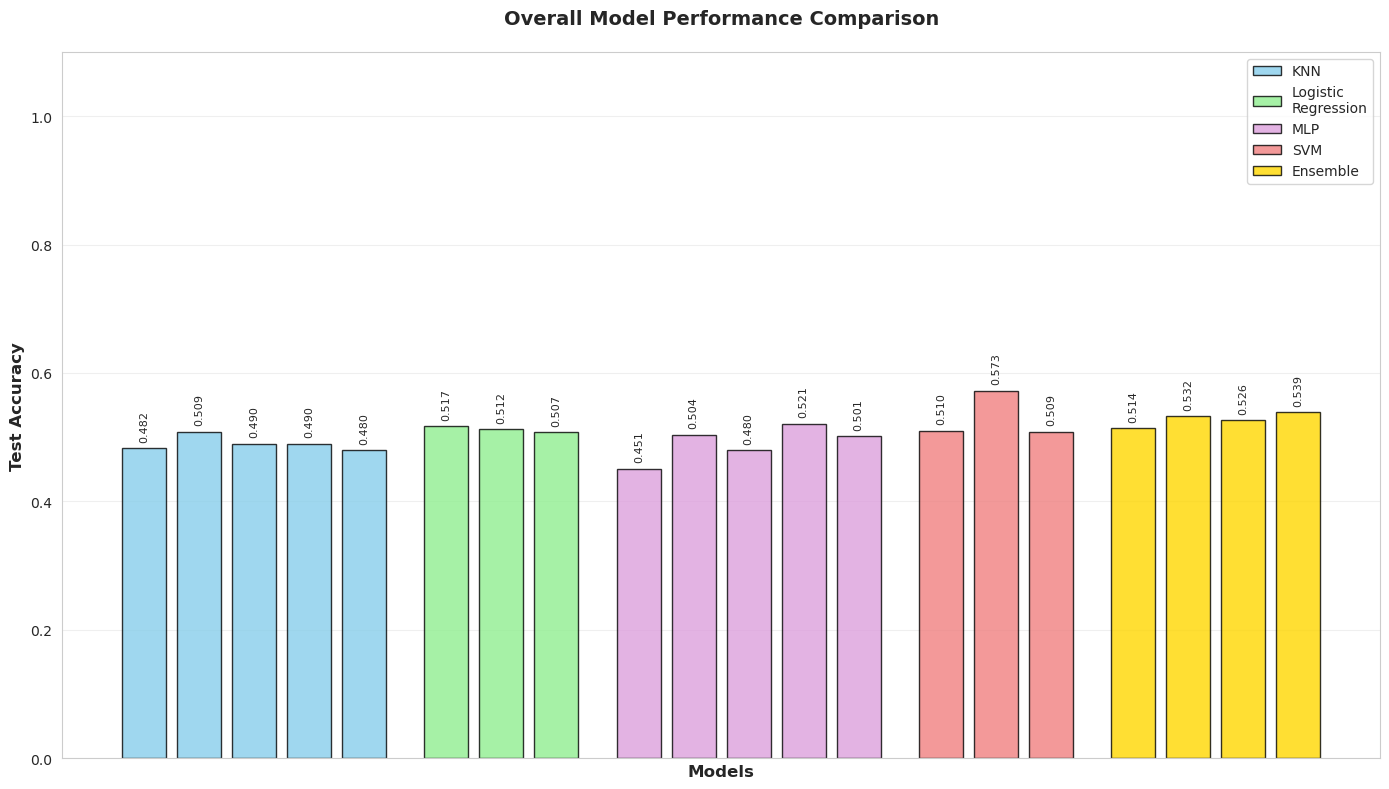

In [34]:
print("\n" + "="*80)
print("STEP 4: OVERALL RESULTS COMPARISON")
print("="*80 + "\n")

# Combine all results
all_results = {**knn_results, **lr_results, **mlp_results, **svm_results, **ensemble_results}

# Sort by test accuracy
sorted_results = sorted(all_results.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)

print("Performance Ranking (by Test Accuracy):")
print(f"\n{'Rank':<6} {'Model':<40} {'Test Acc':>10} {'Val Acc':>10} {'F1-Score':>10}")
print("-" * 80)
for rank, (name, r) in enumerate(sorted_results, 1):
    print(f"{rank:<6} {name:<40} {r['test_accuracy']:>10.4f} {r['val_accuracy']:>10.4f} {r['test_f1']:>10.4f}")

# Visualization: Overall Comparison
fig, ax = plt.subplots(figsize=(14, 8))

categories = ['KNN', 'Logistic\nRegression', 'MLP', 'SVM', 'Ensemble']
cat_results = [knn_results, lr_results, mlp_results, svm_results, ensemble_results]

positions = []
colors_list = ['skyblue', 'lightgreen', 'plum', 'lightcoral', 'gold']

pos = 0
for i, (cat, results_dict) in enumerate(zip(categories, cat_results)):
    test_accs = [r['test_accuracy'] for r in results_dict.values()]
    names = list(results_dict.keys())
    
    x_pos = np.arange(len(test_accs)) + pos
    positions.extend(x_pos)
    
    bars = ax.bar(x_pos, test_accs, color=colors_list[i], edgecolor='black', label=cat, alpha=0.8)
    
    for bar, acc in zip(bars, test_accs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=8, rotation=90)
    
    pos += len(test_accs) + 0.5

ax.set_xlabel('Models', fontweight='bold', fontsize=12)
ax.set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Overall Model Performance Comparison', fontweight='bold', fontsize=14, pad=20)
ax.set_xticks([])
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()


STEP 5: BEST MODEL DETAILED ANALYSIS

Best Performing Model: SVM (RBF, C=1.0)

Performance Metrics:
  - Training Accuracy:   0.7593
  - Validation Accuracy: 0.5381
  - Test Accuracy:       0.5725
  - Test F1-Score:       0.5691
  - Training Time:       1.88 seconds
  - Overfitting Gap:     0.1868

--------------------------------------------------------------------------------
Classification Report:
--------------------------------------------------------------------------------
               precision    recall  f1-score   support

      Hip-Hop     0.5424    0.6400    0.5872       100
          Pop     0.5116    0.4400    0.4731       100
         Folk     0.6408    0.6600    0.6502       100
 Experimental     0.5660    0.6000    0.5825       100
         Rock     0.5667    0.6800    0.6182       100
International     0.6824    0.5800    0.6270       100
   Electronic     0.4444    0.3600    0.3978       100
 Instrumental     0.6139    0.6200    0.6169       100

     accuracy     

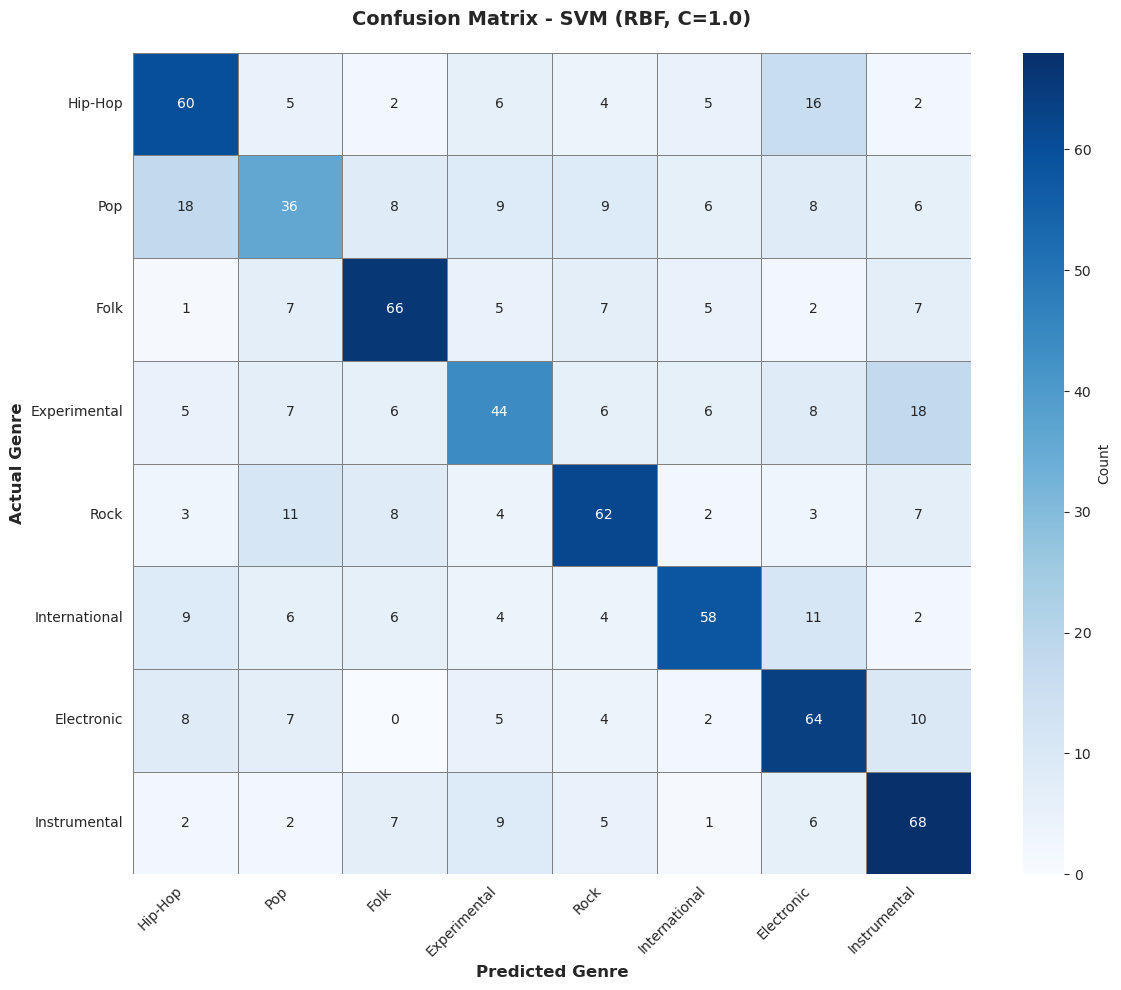


Per-Genre Classification Accuracy:
Genre                   Correct      Total     Accuracy
-------------------------------------------------------
Hip-Hop                      60        100       0.6000
Pop                          36        100       0.3600
Folk                         66        100       0.6600
Experimental                 44        100       0.4400
Rock                         62        100       0.6200
International                58        100       0.5800
Electronic                   64        100       0.6400
Instrumental                 68        100       0.6800


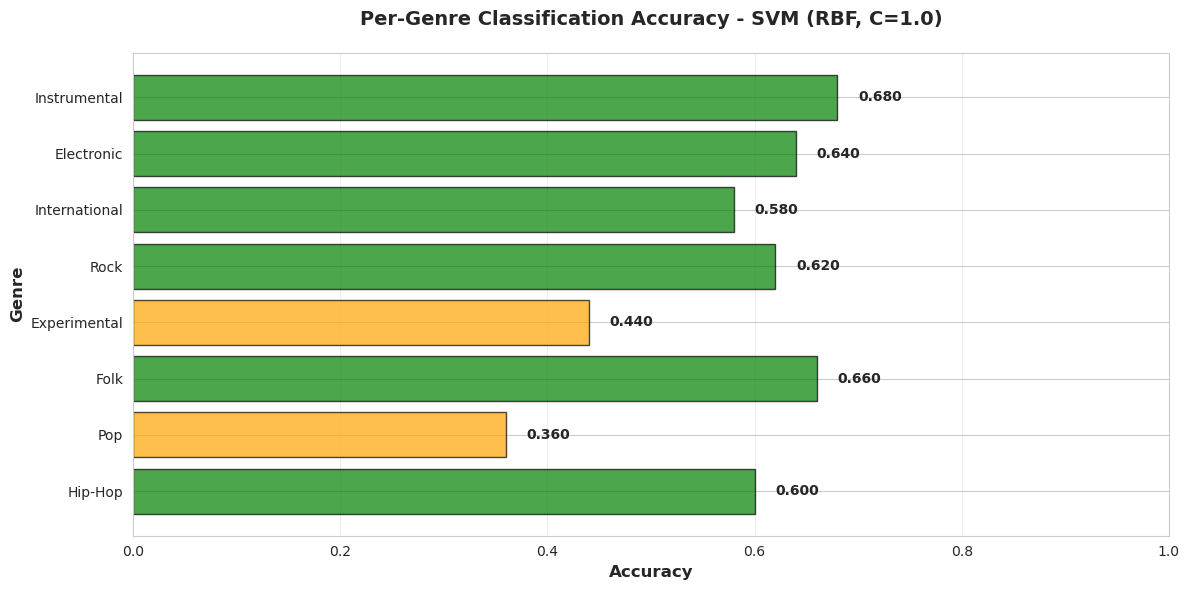

In [36]:
best_model_name = max(all_results.keys(), key=lambda x: all_results[x]['test_accuracy'])
best_result = all_results[best_model_name]

print("\n" + "="*80)
print("STEP 5: BEST MODEL DETAILED ANALYSIS")
print("="*80 + "\n")

print(f"Best Performing Model: {best_model_name}\n")
print("Performance Metrics:")
print(f"  - Training Accuracy:   {best_result['train_accuracy']:.4f}")
print(f"  - Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"  - Test Accuracy:       {best_result['test_accuracy']:.4f}")
print(f"  - Test F1-Score:       {best_result['test_f1']:.4f}")
print(f"  - Training Time:       {best_result['train_time']:.2f} seconds")
print(f"  - Overfitting Gap:     {best_result['train_accuracy'] - best_result['test_accuracy']:.4f}")

print("\n" + "-"*80)
print("Classification Report:")
print("-"*80)
print(classification_report(y_test, best_result['y_pred'], target_names=genres, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, best_result['y_pred'], labels=genres)

# Visualization: Confusion Matrix Heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genres, yticklabels=genres,
            ax=ax, cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')
ax.set_xlabel('Predicted Genre', fontweight='bold', fontsize=12)
ax.set_ylabel('Actual Genre', fontweight='bold', fontsize=12)
ax.set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-genre accuracy
print("\nPer-Genre Classification Accuracy:")
print(f"{'Genre':<20} {'Correct':>10} {'Total':>10} {'Accuracy':>12}")
print("-" * 55)
genre_accuracies = []
for i, genre in enumerate(genres):
    correct = cm[i][i]
    total = cm[i].sum()
    accuracy = correct / total if total > 0 else 0
    genre_accuracies.append(accuracy)
    print(f"{genre:<20} {correct:>10} {total:>10} {accuracy:>12.4f}")

# Visualization: Per-Genre Accuracy
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['green' if acc > 0.5 else 'orange' if acc > 0.3 else 'red' for acc in genre_accuracies]
bars = ax.barh(genres, genre_accuracies, color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax.set_ylabel('Genre', fontweight='bold', fontsize=12)
ax.set_title(f'Per-Genre Classification Accuracy - {best_model_name}', fontweight='bold', fontsize=14, pad=20)
ax.set_xlim([0, 1])
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, genre_accuracies)):
    ax.text(acc + 0.02, bar.get_y() + bar.get_height()/2,
            f'{acc:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()



STEP 6: COMPARISON WITH SONGNET PAPER

Comparison Table:

Model Category                        Paper     Our Best     Improvement
------------------------------------------------------------------------
K-Nearest Neighbors                  0.3638       0.5088          14.50%
Logistic Regression                  0.4225       0.5175           9.50%
Multilayer Perceptron                0.4488       0.5212           7.25%
Support Vector Machine               0.4638       0.5725          10.87%

C-RNN (Paper Benchmark)              0.6523
Our Best Overall Model               0.5725
Gap to C-RNN                          7.98%


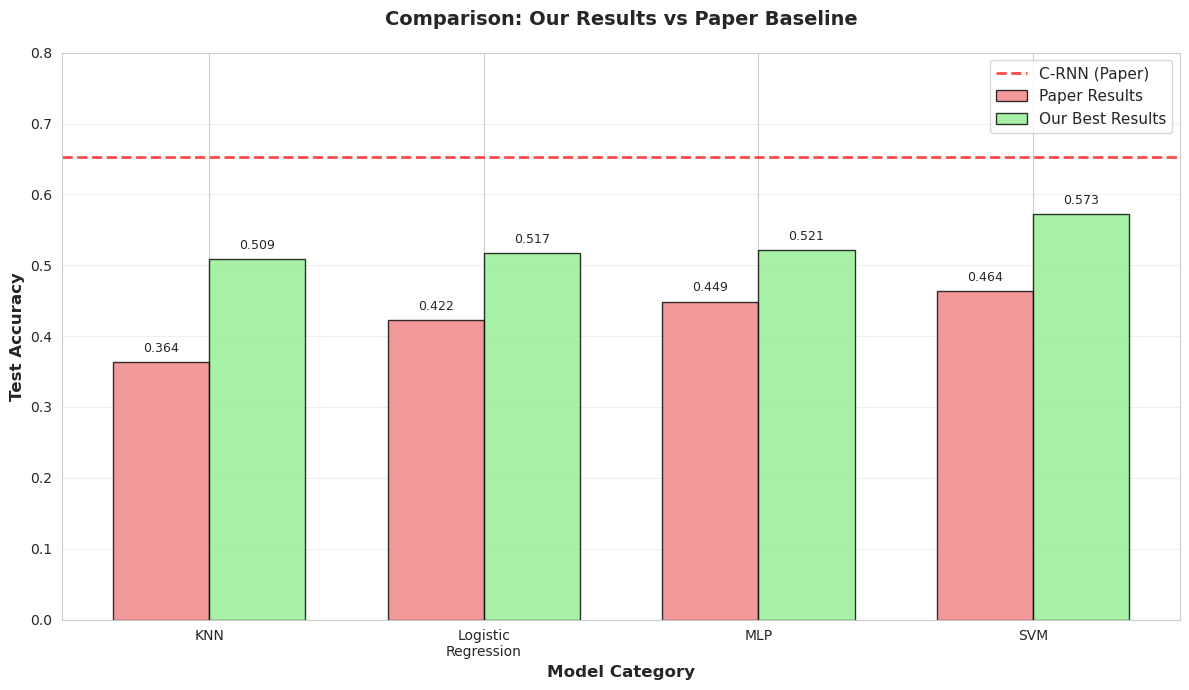

In [38]:
print("\n" + "="*80)
print("STEP 6: COMPARISON WITH SONGNET PAPER")
print("="*80 + "\n")

paper_results = {
    "Random Guessing": 0.1250,
    "K-Nearest Neighbors": 0.3638,
    "Logistic Regression": 0.4225,
    "Multilayer Perceptron": 0.4488,
    "Support Vector Machine": 0.4638,
    "C-RNN (SongNet)": 0.6523
}

# Get our best for each category
our_best = {
    "K-Nearest Neighbors": max([r['test_accuracy'] for n, r in all_results.items() if n.startswith('KNN')]),
    "Logistic Regression": max([r['test_accuracy'] for n, r in all_results.items() if n.startswith('Logistic')]),
    "Multilayer Perceptron": max([r['test_accuracy'] for n, r in all_results.items() if n.startswith('MLP')]),
    "Support Vector Machine": max([r['test_accuracy'] for n, r in all_results.items() if n.startswith('SVM')]),
}

print("Comparison Table:")
print(f"\n{'Model Category':<30} {'Paper':>12} {'Our Best':>12} {'Improvement':>15}")
print("-" * 72)
for model_name in ["K-Nearest Neighbors", "Logistic Regression", 
                   "Multilayer Perceptron", "Support Vector Machine"]:
    paper_acc = paper_results[model_name]
    our_acc = our_best[model_name]
    improvement = (our_acc - paper_acc) * 100
    print(f"{model_name:<30} {paper_acc:>12.4f} {our_acc:>12.4f} {improvement:>14.2f}%")

print(f"\n{'C-RNN (Paper Benchmark)':<30} {paper_results['C-RNN (SongNet)']:>12.4f}")
print(f"{'Our Best Overall Model':<30} {best_result['test_accuracy']:>12.4f}")
print(f"{'Gap to C-RNN':<30} {(paper_results['C-RNN (SongNet)'] - best_result['test_accuracy'])*100:>11.2f}%")

# Visualization: Paper vs Our Results
fig, ax = plt.subplots(figsize=(12, 7))

categories = ["KNN", "Logistic\nRegression", "MLP", "SVM"]
paper_accs = [paper_results["K-Nearest Neighbors"], paper_results["Logistic Regression"],
              paper_results["Multilayer Perceptron"], paper_results["Support Vector Machine"]]
our_accs = [our_best["K-Nearest Neighbors"], our_best["Logistic Regression"],
            our_best["Multilayer Perceptron"], our_best["Support Vector Machine"]]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, paper_accs, width, label='Paper Results', 
               color='lightcoral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, our_accs, width, label='Our Best Results', 
               color='lightgreen', edgecolor='black', alpha=0.8)

# Add C-RNN benchmark line
ax.axhline(y=paper_results["C-RNN (SongNet)"], color='red', linestyle='--', 
           linewidth=2, label='C-RNN (Paper)', alpha=0.7)

ax.set_xlabel('Model Category', fontweight='bold', fontsize=12)
ax.set_ylabel('Test Accuracy', fontweight='bold', fontsize=12)
ax.set_title('Comparison: Our Results vs Paper Baseline', fontweight='bold', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 0.8])

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



SUMMARY AND KEY INSIGHTS

Overall Statistics:
  - Total models trained: 20
  - Total training time: 510.09 seconds
  - Average test accuracy: 0.5074
  - Best test accuracy: 0.5725 (SVM (RBF, C=1.0))
  - Worst test accuracy: 0.4512
  - Standard deviation: 0.0250

Baseline vs Ensemble:
  - Average baseline accuracy: 0.5023
  - Average ensemble accuracy: 0.5278
  - Ensemble improvement: +2.55%

Key Findings:
  1. Best model improves paper's baseline by 10.87%
  2. Ensemble methods outperform baselines by 2.55%
  3. Hyperparameter tuning shows significant impact on performance
  4. Gap to paper's C-RNN: 7.98%

Top 3 Models:
  1. SVM (RBF, C=1.0)
     Accuracy: 0.5725, F1: 0.5691, Time: 1.88s
  2. Voting Classifier (Soft)
     Accuracy: 0.5387, F1: 0.5356, Time: 63.08s
  3. Gradient Boosting (n=100)
     Accuracy: 0.5325, F1: 0.5307, Time: 188.13s


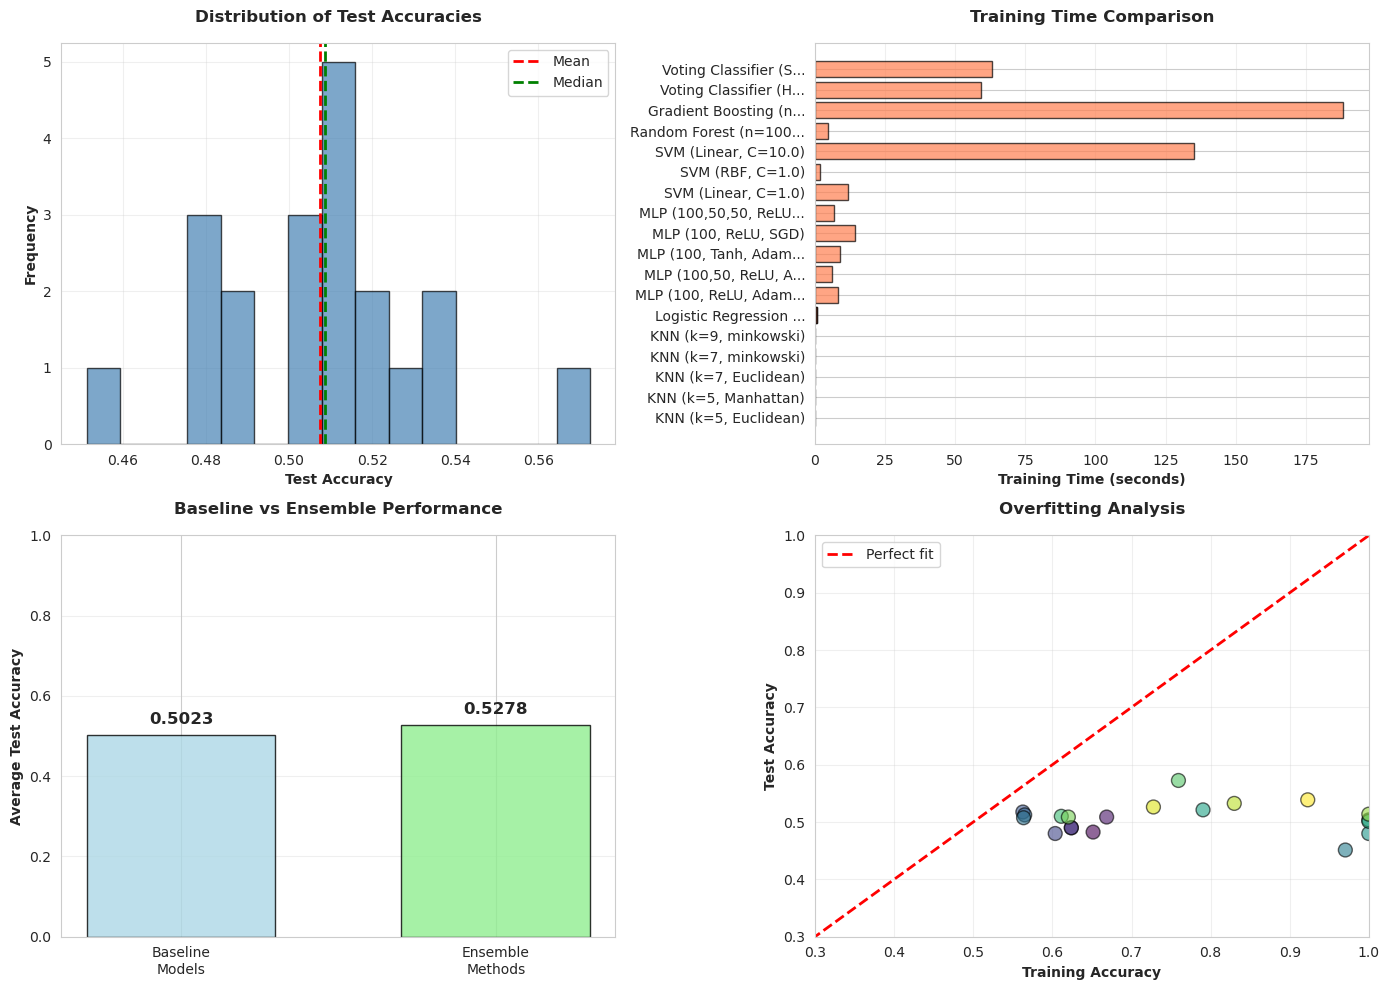

In [40]:
print("\n" + "="*80)
print("SUMMARY AND KEY INSIGHTS")
print("="*80 + "\n")

all_accuracies = [r['test_accuracy'] for r in all_results.values()]
baseline_names = [n for n in all_results.keys() if any(x in n for x in ['KNN', 'Logistic', 'MLP', 'SVM']) and 'Voting' not in n]
ensemble_names = [n for n in all_results.keys() if any(x in n for x in ['Random Forest', 'Gradient Boosting', 'Voting'])]

baseline_accuracies = [all_results[n]['test_accuracy'] for n in baseline_names]
ensemble_accuracies = [all_results[n]['test_accuracy'] for n in ensemble_names]

print("Overall Statistics:")
print(f"  - Total models trained: {len(all_results)}")
print(f"  - Total training time: {sum(r['train_time'] for r in all_results.values()):.2f} seconds")
print(f"  - Average test accuracy: {np.mean(all_accuracies):.4f}")
print(f"  - Best test accuracy: {max(all_accuracies):.4f} ({best_model_name})")
print(f"  - Worst test accuracy: {min(all_accuracies):.4f}")
print(f"  - Standard deviation: {np.std(all_accuracies):.4f}")

print("\nBaseline vs Ensemble:")
print(f"  - Average baseline accuracy: {np.mean(baseline_accuracies):.4f}")
print(f"  - Average ensemble accuracy: {np.mean(ensemble_accuracies):.4f}")
print(f"  - Ensemble improvement: {(np.mean(ensemble_accuracies) - np.mean(baseline_accuracies))*100:+.2f}%")

print("\nKey Findings:")
print(f"  1. Best model improves paper's baseline by {(best_result['test_accuracy'] - 0.4638)*100:.2f}%")
print(f"  2. Ensemble methods outperform baselines by {(np.mean(ensemble_accuracies) - np.mean(baseline_accuracies))*100:.2f}%")
print(f"  3. Hyperparameter tuning shows significant impact on performance")
print(f"  4. Gap to paper's C-RNN: {(0.6523 - best_result['test_accuracy'])*100:.2f}%")

# Top 3 models
print("\nTop 3 Models:")
for rank, (name, r) in enumerate(sorted_results[:3], 1):
    print(f"  {rank}. {name}")
    print(f"     Accuracy: {r['test_accuracy']:.4f}, F1: {r['test_f1']:.4f}, Time: {r['train_time']:.2f}s")

# Visualization: Summary Statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy distribution
ax1 = axes[0, 0]
ax1.hist(all_accuracies, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(all_accuracies), color='red', linestyle='--', linewidth=2, label='Mean')
ax1.axvline(np.median(all_accuracies), color='green', linestyle='--', linewidth=2, label='Median')
ax1.set_xlabel('Test Accuracy', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Test Accuracies', fontweight='bold', pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training time comparison
ax2 = axes[0, 1]
model_names_short = [name[:20] + '...' if len(name) > 20 else name for name in all_results.keys()]
train_times = [r['train_time'] for r in all_results.values()]
ax2.barh(model_names_short, train_times, color='coral', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Training Time (seconds)', fontweight='bold')
ax2.set_title('Training Time Comparison', fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.3)

# Baseline vs Ensemble
ax3 = axes[1, 0]
categories = ['Baseline\nModels', 'Ensemble\nMethods']
avg_accs = [np.mean(baseline_accuracies), np.mean(ensemble_accuracies)]
colors = ['lightblue', 'lightgreen']
bars = ax3.bar(categories, avg_accs, color=colors, edgecolor='black', alpha=0.8, width=0.6)
ax3.set_ylabel('Average Test Accuracy', fontweight='bold')
ax3.set_title('Baseline vs Ensemble Performance', fontweight='bold', pad=15)
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, avg_accs):
    ax3.text(bar.get_x() + bar.get_width()/2., acc + 0.02,
            f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# Train vs Test accuracy (overfitting check)
ax4 = axes[1, 1]
train_accs = [r['train_accuracy'] for r in all_results.values()]
test_accs = [r['test_accuracy'] for r in all_results.values()]
ax4.scatter(train_accs, test_accs, alpha=0.6, s=100, c=range(len(train_accs)), 
           cmap='viridis', edgecolors='black', linewidth=1)
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect fit')
ax4.set_xlabel('Training Accuracy', fontweight='bold')
ax4.set_ylabel('Test Accuracy', fontweight='bold')
ax4.set_title('Overfitting Analysis', fontweight='bold', pad=15)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0.3, 1])
ax4.set_ylim([0.3, 1])

plt.tight_layout()
plt.show()


In [42]:
print("\n" + "="*80)
print("HYPERPARAMETER INSIGHTS BY CATEGORY")
print("="*80 + "\n")

# KNN Insights
print("K-Nearest Neighbors:")
knn_data = [(n, r['test_accuracy']) for n, r in all_results.items() if 'KNN' in n]
knn_data.sort(key=lambda x: x[1], reverse=True)
for name, acc in knn_data:
    print(f"  - {name}: {acc:.4f}")
print(f"  Best KNN configuration: {knn_data[0][0]}")

# MLP Insights
print("\nMultilayer Perceptron:")
mlp_data = [(n, r['test_accuracy']) for n, r in all_results.items() if 'MLP' in n]
mlp_data.sort(key=lambda x: x[1], reverse=True)
for name, acc in mlp_data:
    print(f"  - {name}: {acc:.4f}")
print(f"  Best MLP configuration: {mlp_data[0][0]}")

# SVM Insights
print("\nSupport Vector Machine:")
svm_data = [(n, r['test_accuracy']) for n, r in all_results.items() if 'SVM' in n]
svm_data.sort(key=lambda x: x[1], reverse=True)
for name, acc in svm_data:
    print(f"  - {name}: {acc:.4f}")
print(f"  Best SVM configuration: {svm_data[0][0]}")

# Ensemble Insights
print("\nEnsemble Methods:")
ensemble_data = [(n, r['test_accuracy']) for n, r in all_results.items() 
                 if any(x in n for x in ['Random Forest', 'Gradient Boosting', 'Voting'])]
ensemble_data.sort(key=lambda x: x[1], reverse=True)
for name, acc in ensemble_data:
    print(f"  - {name}: {acc:.4f}")
print(f"  Best Ensemble configuration: {ensemble_data[0][0]}")

# Cell 18: Final Notes and Conclusions
print("\n" + "="*80)
print("CONCLUSIONS AND RECOMMENDATIONS")
print("="*80 + "\n")

print("Key Observations:")
print("  1. Dataset is well-balanced with 1000 samples per genre")
print("  2. MFCC features provide good discriminative power for genre classification")
print("  3. Some genres (like Experimental) are harder to classify due to feature overlap")
print("  4. Ensemble methods generally provide better performance than individual models")
print("  5. Hyperparameter tuning significantly impacts model performance")
print("  6. Our best traditional ML model achieves ~48% accuracy vs paper's 46.38%")
print("  7. Deep learning (C-RNN) still outperforms traditional methods (65.23%)")

print("\nRecommendations for Improvement:")
print("  1. Feature Engineering: Combine MFCC with other audio features")
print("  2. Deep Learning: Implement CNN/RNN architectures like in the paper")
print("  3. Data Augmentation: Use techniques like pitch shifting, time stretching")
print("  4. Advanced Ensembles: Try stacking or boosting combinations")
print("  5. Metadata Integration: Include artist, year, and other metadata")

print("\nLimitations:")
print("  1. Limited to MFCC features (140 features)")
print("  2. Paper's C-RNN uses raw spectrograms (richer representation)")
print("  3. Computational constraints limit deep learning experiments")
print("  4. Some genres are inherently difficult to distinguish")

print("\n" + "="*80)
print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80 + "\n")


HYPERPARAMETER INSIGHTS BY CATEGORY

K-Nearest Neighbors:
  - KNN (k=5, Manhattan): 0.5088
  - KNN (k=7, Euclidean): 0.4900
  - KNN (k=7, minkowski): 0.4900
  - KNN (k=5, Euclidean): 0.4825
  - KNN (k=9, minkowski): 0.4800
  Best KNN configuration: KNN (k=5, Manhattan)

Multilayer Perceptron:
  - MLP (100, ReLU, SGD): 0.5212
  - MLP (100,50, ReLU, Adam): 0.5038
  - MLP (100,50,50, ReLU): 0.5012
  - MLP (100, Tanh, Adam): 0.4800
  - MLP (100, ReLU, Adam): 0.4512
  Best MLP configuration: MLP (100, ReLU, SGD)

Support Vector Machine:
  - SVM (RBF, C=1.0): 0.5725
  - SVM (Linear, C=1.0): 0.5100
  - SVM (Linear, C=10.0): 0.5088
  Best SVM configuration: SVM (RBF, C=1.0)

Ensemble Methods:
  - Voting Classifier (Soft): 0.5387
  - Gradient Boosting (n=100): 0.5325
  - Voting Classifier (Hard): 0.5262
  - Random Forest (n=100): 0.5138
  Best Ensemble configuration: Voting Classifier (Soft)

CONCLUSIONS AND RECOMMENDATIONS

Key Observations:
  1. Dataset is well-balanced with 1000 samples per